# Training LSTM on residuals of physical model

In [29]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from ode_model import LorenzModel
from lstm import WindowedTimeSeries, train_model, predict_autoregressive

Generate data
- 10,000 obs
- noise proportion (observed data)= 0.05
- noise proportion (assimilate data) = 0.01

In [5]:
n = 10000
noise_level = 0.05
assim_noise_level=0.01
time_step = 0.05

data = generate_data(n, noise_level=noise_level, time_step=time_step)
assimilated_data = generate_data(n, noise_level=assim_noise_level, time_step=time_step)

In [6]:
data.shape

(10000, 3)

Create imperfect Lorenz Model
- Set c = 12.5 (MSE LSTM aprrox = LSTM ODE for k=10)

In [7]:
ode_model = LorenzModel(c=12.5)

Predict k steps ahead using ODE model
- Compute residuals and inspect

In [8]:
k=10
preds_ode = ode_model.predict(y0=assimilated_data, t_step=time_step*k)

In [9]:
true = data
true.shape

(10000, 3)

In [10]:
residuals_ode = true[k: , :] - preds_ode[:-k, :]

In [11]:
residuals_ode.shape

(9990, 3)

In [12]:
np.mean(residuals_ode ** 2)

11.317342304659611

In [13]:
np.mean(residuals_ode, axis=0)

array([ 0.03360574,  0.01750806, -0.26073072])

In [14]:
residuals_ode.std(axis=0, ddof=1)

array([4.49646465, 2.9299071 , 2.25465132])

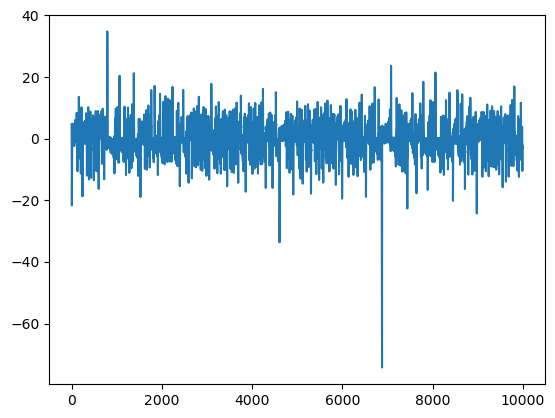

In [15]:
plt.plot(residuals_ode[:,0])
plt.show()

Train LSTM
- Split data into train and test
- convert data to custom class
- Train LSTM

In [16]:
input_series = data[:-k, ]
input_series.shape

(9990, 3)

In [17]:
train_length = int(residuals_ode.shape[0] * 0.8)
val_length = int(residuals_ode.shape[0] * 0.9)
train_target_series = residuals_ode[:train_length, :]
val_target_series = residuals_ode[train_length:val_length, :]
test_target_series = residuals_ode[val_length:, :]
train_input_series = input_series[:train_length, :]
val_input_series = input_series[train_length:val_length, :]
test_input_series = input_series[val_length:, :]


In [26]:
train_dataset = WindowedTimeSeries(train_input_series, train_target_series, 10)
val_dataset = WindowedTimeSeries(val_input_series, val_target_series, 10)
test_dataset = WindowedTimeSeries(test_input_series, test_target_series, 10)

In [25]:
lstm_model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=20,
)

Epoch [10/20], train_loss: 2.8885, val_loss: 3.5361
Early stopping triggered at epoch: 16


In [27]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:


all_preds = []
all_target = []
for X_batch, Y_batch in test_loader:
  preds = predict_autoregressive(lstm_model, X_batch, steps=1)
  all_preds.append(preds)
  all_target.append(Y_batch)


all_preds = torch.cat(all_preds)
all_target = torch.cat(all_target)

mse = nn.MSELoss()(all_preds, all_target)
print(f"MSE: {mse}")

MSE: 2.4632608890533447


In [32]:
c_range = np.linspace(11,16,11)
# k_range = [1,5,10,15,20]
k_range = np.arange(1,21)
MSE = np.zeros((len(k_range), len(c_range)))

for i_k, k in enumerate(k_range):
  for i_c, c in enumerate(c_range):
    ode_model.update_params(c=c)
    preds_ode = ode_model.predict(y0=assimilated_data, t_step=time_step*k)
    true = data[:-k,]

    residuals_ode = data[k: , :] - preds_ode[:-k, :]

    train_length = int(residuals_ode.shape[0] * 0.8)
    val_length = int(residuals_ode.shape[0] * 0.9)
    train_target_series = residuals_ode[:train_length, :]
    val_target_series = residuals_ode[train_length:val_length, :]
    test_target_series = residuals_ode[val_length:, :]
    train_input_series = true[:train_length, :]
    val_input_series = true[train_length:val_length, :]
    test_input_series = true[val_length:, :]

    train_dataset = WindowedTimeSeries(train_input_series, train_target_series, 10)
    val_dataset = WindowedTimeSeries(val_input_series, val_target_series, 10)
    test_dataset = WindowedTimeSeries(test_input_series, test_target_series, 10)

    lstm_model = train_model(
      train_dataset=train_dataset,
      val_dataset=val_dataset,
      hidden_size=100,
      num_layers=1,
      batch_size=64,
      learning_rate=0.01,
      num_epochs=50,
      silence=True
    )

    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    all_preds = []
    all_target = []
    for X_batch, Y_batch in test_loader:
      preds = predict_autoregressive(lstm_model, X_batch, steps=1)
      all_preds.append(preds)
      all_target.append(Y_batch)

    all_preds = torch.cat(all_preds)
    all_target = torch.cat(all_target)  

    mse = nn.MSELoss()(all_preds, all_target)
    MSE[i_k, i_c] = mse
    print(f"k: {k}, c: {c:.2f}, MSE: {mse:.2f}")


k: 1, c: 11.00, MSE: 0.71
k: 1, c: 11.50, MSE: 0.76
k: 1, c: 12.00, MSE: 0.71
k: 1, c: 12.50, MSE: 0.73
k: 1, c: 13.00, MSE: 0.70
k: 1, c: 13.50, MSE: 0.70
k: 1, c: 14.00, MSE: 0.70
k: 1, c: 14.50, MSE: 0.70
k: 1, c: 15.00, MSE: 0.69
k: 1, c: 15.50, MSE: 0.69
k: 1, c: 16.00, MSE: 0.70
k: 2, c: 11.00, MSE: 0.75
k: 2, c: 11.50, MSE: 0.73
k: 2, c: 12.00, MSE: 0.74
k: 2, c: 12.50, MSE: 0.73
k: 2, c: 13.00, MSE: 0.73
k: 2, c: 13.50, MSE: 0.74
k: 2, c: 14.00, MSE: 0.71
k: 2, c: 14.50, MSE: 0.73
k: 2, c: 15.00, MSE: 0.72
k: 2, c: 15.50, MSE: 0.74
k: 2, c: 16.00, MSE: 0.70
k: 3, c: 11.00, MSE: 0.78
k: 3, c: 11.50, MSE: 0.88
k: 3, c: 12.00, MSE: 0.78
k: 3, c: 12.50, MSE: 0.79
k: 3, c: 13.00, MSE: 0.72
k: 3, c: 13.50, MSE: 0.74
k: 3, c: 14.00, MSE: 0.73
k: 3, c: 14.50, MSE: 0.72
k: 3, c: 15.00, MSE: 0.74
k: 3, c: 15.50, MSE: 0.72
k: 3, c: 16.00, MSE: 0.72
k: 4, c: 11.00, MSE: 0.89
k: 4, c: 11.50, MSE: 0.80
k: 4, c: 12.00, MSE: 0.82
k: 4, c: 12.50, MSE: 0.79
k: 4, c: 13.00, MSE: 0.73
k: 4, c: 13.

In [33]:
ds = xr.Dataset(
  data_vars=dict(
    mse=(["k","c"], MSE),
  ),
  coords=dict(
    k=k_range,
    c=c_range,
  ),
  attrs=dict(
    time_step=time_step,
    description="MSE of boosted model",
  )
)

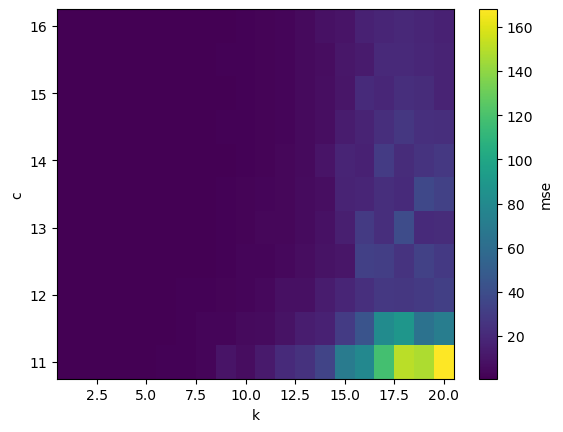

In [34]:
ds.mse.plot(x="k", y='c')

In [35]:
out_path = Path("../data/processed/mse_boosted_model.nc")

ds.to_netcdf(out_path)